Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         xx/xx/xxxx
Name:         student name
Worked with:  other students' name
Location:     nyc17_ds10/student_submissions/challenges/01-mta/shaikh_reshama/challenge_set_1_reshama.ipynb

In [2]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Challenge 1

In [3]:
import pandas as pd
import datetime

In [4]:
def clean_data(df):
    
    df.columns = ['C/A','UNIT','SCP','STATION','LINENAME',\
              'DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
    
    df['converted_time'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
    df['turnstiles'] = df['C/A'] + '-' + df['UNIT'] + '-' + df['SCP'] + '-' + df['STATION']
    
    df_sorted = df.sort_values(['turnstiles', 'converted_time'])
    
    turnstile_df = df_sorted.groupby('turnstiles')
    df_sorted['entries_diff'] = turnstile_df['ENTRIES'].diff()
    df_sorted['exits_diff'] = turnstile_df['EXITS'].diff()
    
    df_sorted['entries_diff'] = df_sorted['entries_diff'].fillna(0)
    df_sorted['exits_diff'] = df_sorted['exits_diff'].fillna(0)
    
    
    return df_sorted

In [5]:
def remove_outliers(df_sorted):
    # calculates IQR for entries_diff
    Q3 = df_sorted['entries_diff'].quantile(0.75) 
    Q1 = df_sorted['entries_diff'].quantile(0.25)
    IQR = Q3 - Q1
    # calculates IQR range using outliers 
    IQR_range = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    IQR_range
    # removes values outside of lower and upper bounds
    df_sorted = df_sorted[df_sorted['entries_diff'].between(IQR_range[0], IQR_range[1])]
    # repeats process for exits_diff
    Q3_2 = df_sorted['exits_diff'].quantile(0.75) 
    Q1_2 = df_sorted['exits_diff'].quantile(0.25)
    IQR_2 = Q3_2 - Q1_2
    IQR_range_2 = (Q1_2 - 1.5 * IQR, Q3_2 + 1.5 * IQR)
    IQR_range_2
    df_sorted = df_sorted[df_sorted['exits_diff'].between(IQR_range_2[0], IQR_range_2[1])]
    return df_sorted

In [28]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190803.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190810.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190817.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190824.txt')
df5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190831.txt')
df_sorted = remove_outliers(clean_data(df1))


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Daily Entries For Turnstile A002-R051-02-00-01-59 ST')

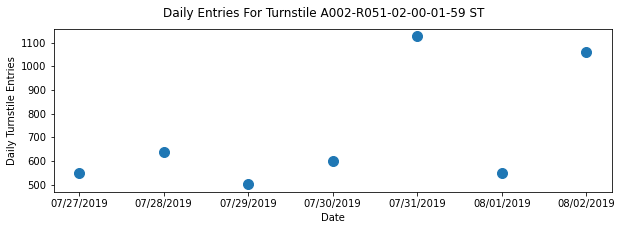

In [8]:
#Filter DF for data of just 1 turnstile, sort by date
single_turnstile = df_sorted[df_sorted.turnstiles == 'A002-R051-02-00-01-59 ST']
single_turnstile_sorted = single_turnstile.groupby('DATE').sum()

#Plot daily entries for 1 turnstile
plt.figure(figsize=(10,3))
x = single_turnstile_sorted.index
y = single_turnstile_sorted['entries_diff']
plt.scatter(x, y, s=100)
plt.xlabel('Date')
plt.ylabel('Daily Turnstile Entries')
plt.suptitle('Daily Entries For Turnstile A002-R051-02-00-01-59 ST'  )

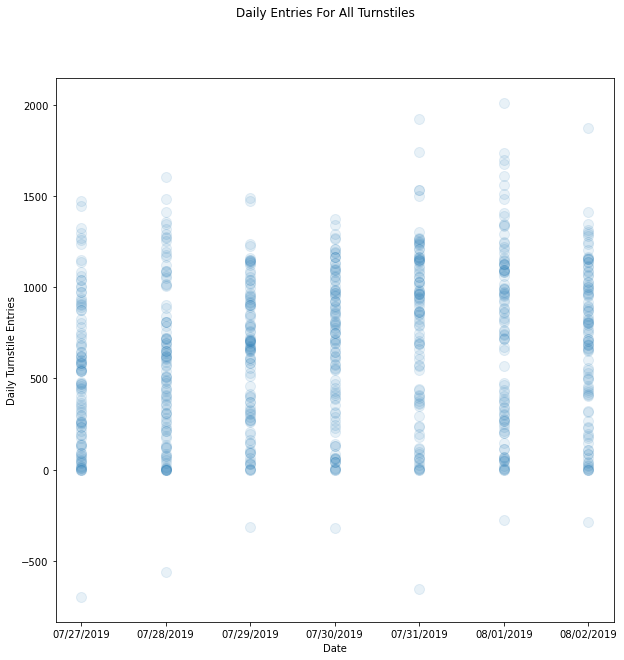

In [105]:
def plot_daily_turnstile_entries(df_sorted, station=None): 
    if isinstance(station, str) != True and station !=None:
        raise TypeError('Station should be a string')
    if station != None:
        df_sorted = df_sorted[df_sorted.STATION == station]

    
    df_sorted_turnstiles_date = df_sorted.groupby(['turnstiles', 'DATE']).sum()
    df_sorted_turnstiles = df_sorted_turnstiles_date.reset_index(level=['DATE'])
    plt.figure(figsize=(10,10))
    x = df_sorted_turnstiles.DATE
    y = df_sorted_turnstiles.entries_diff
    plt.scatter(x,y,s=100,alpha=0.1)
    plt.xlabel('Date')
    plt.ylabel('Daily Turnstile Entries')
    plt.suptitle('Daily Entries For All Turnstiles')
    
plot_daily_turnstile_entries(df_sorted, station = '34 ST-PENN STA')